# Exploring Dandiset 001195: Dorsal Raphe Dopamine Projections and Loneliness-like States

> **Note**: This notebook was generated with AI assistance. Please review all code and results carefully.

## Overview
This notebook explores data from [DANDI:001195](https://dandiarchive.org/dandiset/001195/0.250408.1733), which investigates how distinct dopamine projections from the dorsal raphe nucleus (DRN) modulate aspects of social behavior and affective state in mice. The study examines DRN dopamine neuron projections to different brain regions (BNST, CeA, BLP) using electrophysiology and optogenetics.

### This Notebook Covers:
1. Loading and exploring NWB files using the DANDI API
2. Examining experimental metadata and protocols
3. Visualizing intracellular recordings and stimulation patterns
4. Providing example code for batch processing

### Required Packages
```python
dandi
pynwb
h5py
remfile
numpy
matplotlib
pandas
```

## Accessing the Dandiset

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice
import pandas as pd

# Initialize DANDI API client
client = DandiAPIClient()
dandiset = client.get_dandiset("001195", "0.250408.1733")

# List first 20 NWB files to show organization
assets = dandiset.get_assets_by_glob("*.nwb")
print('Example NWB files in the Dandiset:\n')
for asset in islice(assets, 20):
    print(f'- {asset.path} ({asset.size / 1e6:.2f} MB)')

Example NWB files in the Dandiset:

- sub-23/sub-23_ses-20150324T134114_slice-slice-1_cell-C1_icephys.nwb (37.68 MB)
- sub-23/sub-23_ses-20150324T161217_slice-slice-2_cell-B3_icephys.nwb (39.65 MB)
- sub-235/sub-235_ses-20200921T142415_slice-slice-1_cell-C3_icephys.nwb (13.58 MB)
- sub-23/sub-23_ses-20150324T154615_slice-slice-2_cell-B2_icephys.nwb (42.28 MB)
- sub-23/sub-23_ses-20150324T152016_slice-slice-2_cell-B1_icephys.nwb (84.23 MB)
- sub-235/sub-235_ses-20200921T150553_slice-slice-1_cell-C5_icephys.nwb (18.73 MB)
- sub-235/sub-235_ses-20200921T131057_slice-slice-1_cell-C1_icephys.nwb (309.75 MB)
- sub-235/sub-235_ses-20200921T164032_slice-slice-2_cell-C8_icephys.nwb (20.85 MB)
- sub-235/sub-235_ses-20200921T134852_slice-slice-1_cell-C2_icephys.nwb (259.12 MB)
- sub-235/sub-235_ses-20200921T172736_slice-slice-2_cell-C10_icephys.nwb (26.71 MB)
- sub-235/sub-235_ses-20200921T143210_slice-slice-1_cell-C4_icephys.nwb (246.33 MB)
- sub-235/sub-235_ses-20200921T151331_slice-slice-1_cel

## Loading and Examining a Representative NWB File

In [2]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt

# Select example file
nwb_path = 'sub-23/sub-23_ses-20150324T134114_slice-slice-1_cell-C1_icephys.nwb'
asset = next(dandiset.get_assets_by_glob(nwb_path))

# Stream file without downloading
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

## Experimental Metadata
Let's examine the key metadata for this recording:

In [3]:
# Extract metadata
subject = nwb.subject
lab_md = nwb.lab_meta_data['DandiIcephysMetadata']
meta = {
    'Subject ID': getattr(subject, 'subject_id', ''),
    'Strain': getattr(subject, 'strain', ''),
    'Genotype': getattr(subject, 'genotype', ''),
    'Sex': getattr(subject, 'sex', ''),
    'Species': getattr(subject, 'species', ''),
    'Description': getattr(subject, 'description', ''),
    'Experimenter': nwb.experimenter[0] if nwb.experimenter else '',
    'Lab': getattr(nwb, 'lab', ''),
    'Institution': getattr(nwb, 'institution', ''),
    'Cell ID': getattr(lab_md, 'cell_id', ''),
    'Slice ID': getattr(lab_md, 'slice_id', ''),
    'Targeted Layer/Region': getattr(lab_md, 'targeted_layer', ''),
    'Inferred Layer/Region': getattr(lab_md, 'inferred_layer', ''),
    'Session Date': str(nwb.session_start_time),
}

for k, v in meta.items():
    print(f'{k}: {v}')

Subject ID: 23
Strain: DAT::Cre
Genotype: heterozygote
Sex: F
Species: Mus musculus
Description: AAV5-DIO-ChR2-eYFP into DRN
Experimenter: Matthews, Gillian
Lab: Kay Tye Lab
Institution: Massachusetts Institute of Technology
Cell ID: C1
Slice ID: slice 1
Targeted Layer/Region: CeA
Inferred Layer/Region: CeA
Session Date: 2015-03-24 13:41:14-07:00


## Available Stimulus Protocols

In [4]:
# Summarize stimulus protocols
stim_keys = list(nwb.stimulus.keys())
stim_desc = []
for key in stim_keys:
    stim = nwb.stimulus[key]
    stim_desc.append((key, stim.description.strip()))

# Get unique protocols
unique_proto = sorted(set(desc for k, desc in stim_desc))

print('Stimulus protocols in this recording:\n')
for desc in unique_proto:
    print('-', desc)

Stimulus protocols in this recording:

- Stim type: episodic stimulation, 1 laser pulse, 5ms width, every 30s; @ 0mV
- Stim type: episodic stimulation, 1 laser pulse, 5ms width, every 30s; @-70mV
- Stim type: episodic stimulation, 10* 1Hz laser pulses, 5ms width, every 60s
- Stim type: episodic stimulation, 1s steps, 20pA increments, -120pA to 260pA
- Stim type: episodic stimulation, 8*30Hz laser pulses, 5ms width, every 30s


## Visualizing Intracellular Recordings
Below we plot membrane potential responses and corresponding current stimuli for representative sweeps:

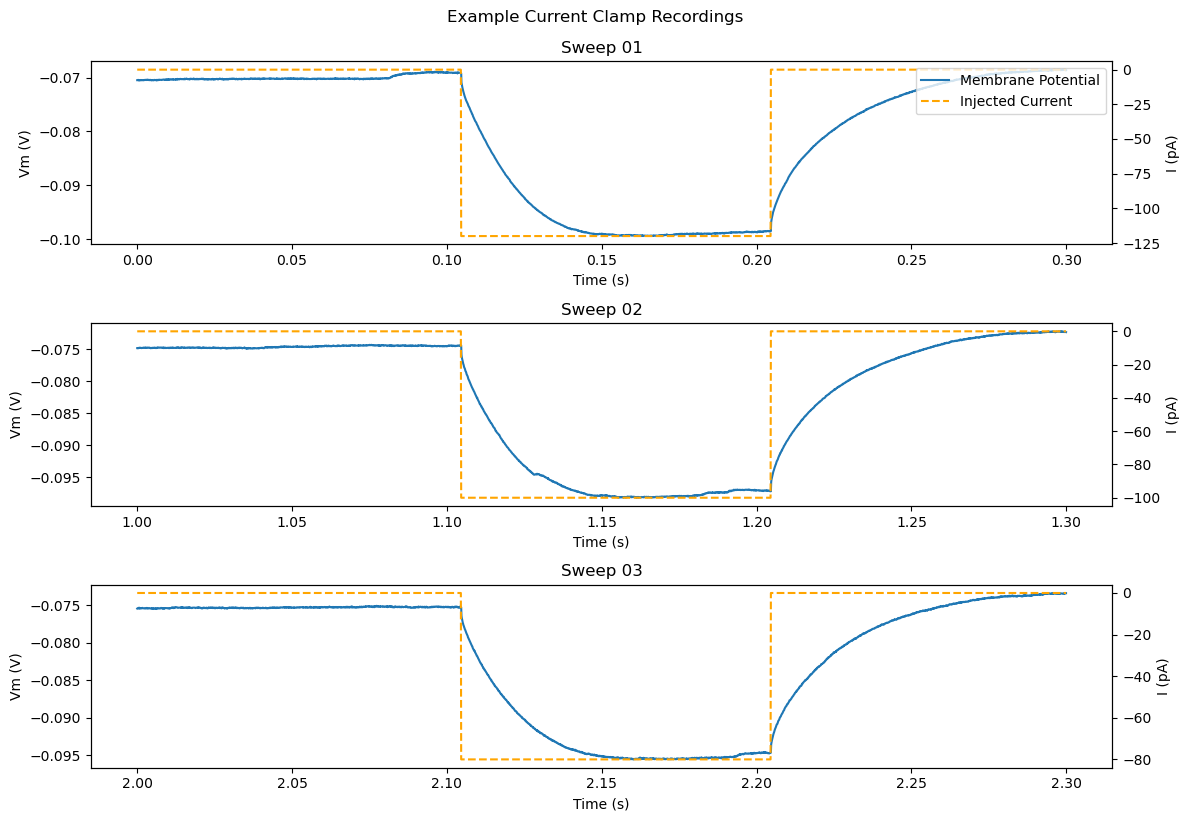

In [5]:
def get_ccs_and_stim(nwb, n, ch):
    """Extract response and stimulus data for a given sweep and channel"""
    resp_key = f"current_clamp-response-{n:02d}-ch-{ch}"
    stim_key = f"stimulus-{n:02d}-ch-{ch}"
    resp = nwb.acquisition[resp_key]
    stim = nwb.stimulus[stim_key]
    t = np.arange(resp.data.shape[0]) / resp.rate + resp.starting_time
    return t, resp.data[:] * resp.conversion, stim.data[:] * stim.conversion, stim.unit, resp.unit

# Create figure
plt.figure(figsize=(12, 8))
for i, n in enumerate([1, 2, 3]):
    for ch in [0]:  # Just plot channel 0 for clarity
        t, resp_v, stim_i, stim_unit, resp_unit = get_ccs_and_stim(nwb, n, ch)
        
        # Plot response
        ax = plt.subplot(3, 1, i+1)
        ax.plot(t, resp_v, label='Membrane Potential')
        
        # Plot stimulus on twin axis
        ax2 = ax.twinx()
        ax2.plot(t, stim_i*1e12, color='orange', linestyle='--', label='Injected Current')
        
        # Labels and formatting
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Vm (V)')
        ax2.set_ylabel('I (pA)')
        ax.set_title(f'Sweep {n:02d}')
        
        if n == 1:
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.suptitle('Example Current Clamp Recordings', y=1.02)
plt.show()

## Example Code for Batch Processing
Here's a template for processing multiple NWB files:

In [6]:
def process_nwb_file(asset):
    """Template function for processing a single NWB file"""
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file)
    io = pynwb.NWBHDF5IO(file=h5_file)
    nwb = io.read()
    
    # Extract key metadata
    meta = {
        'subject_id': nwb.subject.subject_id,
        'targeted_region': nwb.lab_meta_data['DandiIcephysMetadata'].targeted_layer,
        'cell_id': nwb.lab_meta_data['DandiIcephysMetadata'].cell_id,
    }
    return meta

# Example: Process first few files
print("Example batch processing output:\n")
for asset in islice(dandiset.get_assets_by_glob("*.nwb"), 3):
    meta = process_nwb_file(asset)
    print(f"File: {asset.path}")
    print(f"Subject: {meta['subject_id']}, Region: {meta['targeted_region']}, Cell: {meta['cell_id']}\n")

Example batch processing output:



File: sub-23/sub-23_ses-20150324T134114_slice-slice-1_cell-C1_icephys.nwb
Subject: 23, Region: CeA, Cell: C1



File: sub-23/sub-23_ses-20150324T161217_slice-slice-2_cell-B3_icephys.nwb
Subject: 23, Region: BNST, Cell: B3



File: sub-235/sub-235_ses-20200921T142415_slice-slice-1_cell-C3_icephys.nwb
Subject: 235, Region: CeA, Cell: C3



## Next Steps
This dataset enables various analyses:
- Characterization of cellular responses to different stimulus protocols
- Comparison of responses across brain regions
- Investigation of optogenetic manipulation effects
- Meta-analysis across multiple cells/subjects

The NWB files contain rich metadata and well-organized experimental data, making it straightforward to:
1. Filter files by subject, brain region, or protocol
2. Extract and analyze specific sweep types
3. Compare responses across conditions
4. Aggregate results across multiple recordings